## Semi-Supervised Learning (SSL)

### SSL 가정

Semi Supervised Learning(SSL, 준지도학습)은 전체 데이터 중 소수의 데이터만 label이 있고, 다수의 데이터는 label이 없는 unlabeled인 상황을 가정한다.

SSL에서는 레이블링된 데이터와 레이블링되지 않은 데이터가 모두 사용된다. 한 쪽의 데이터를 사용해 다른 데이터 학습에서 성능을 높이는 것을 목표로 한다.

SSL 모델을 통해 레이블되지 않은 데이터가 의미 있게 사용되기 위해서는 암묵적/묵시적으로 데이터 분포에 대한 몇 가지 가정이 필요하다.

#### 1. Smoothness

확률 밀도가 높은 지역의 입력값 x1, x2가 가깝다면 각각에 연관된 '레이블' y1, y2도 그래야 한다. 

SSL에서는 이 가정을 unlabel에도 적용하여, x1이 레이블이 있는 데이터고 x2, x3가 레이블이 없는 데이터일 때 x1과 x2가 가깝고, x2와 x3가 가깝다면, 

x1와 x3이 가깝지 않더라도 x3의 레이블이 x1과 유사할 것으로 기대할 수 있다.

추가적으로 보통, 보통 해당 가정을 SSL 에서 가장 중요한 가정이라 말한다.

#### 2. Low-Density

모델의 결정 경계가 데이터의 확률 밀도가 높은 곳을 지나지 않는다는 가정이다. 이는 1번 (Smoothness) 가정과 연관성이 있다. 

Low-density 가정에 따라 모델의 결정 경계를 두면, low-density 지역은 그 주변에 데이터들이 적기 때문에 smoothness 가정을 위반하지 않는다.

반면, High-density 지에에는 데이터들이 많이 모여있기 때문에, 해당 지역에 결정 경계를 높는다면 1번 가정 (가까운 데이터는 같은 레이블을 가진다) 를 위반한다. 

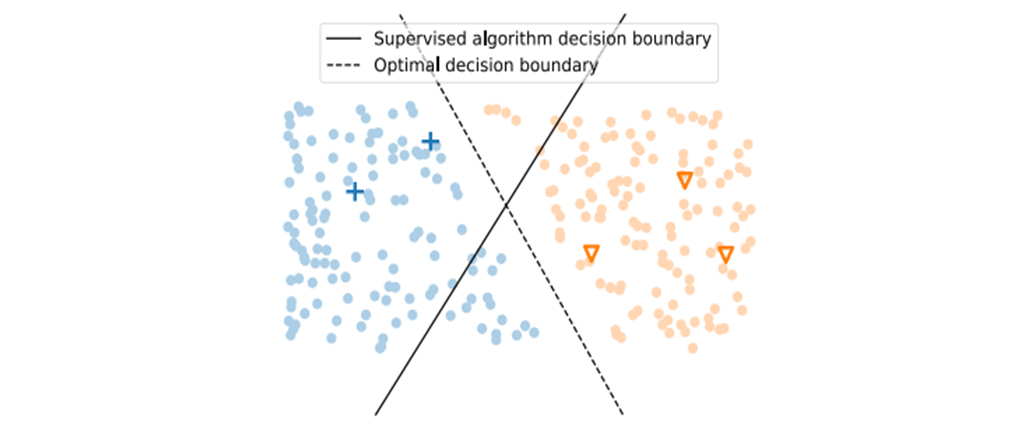

In [1]:
from IPython.display import Image
Image('./images/low-density-assumption.jpeg')

#### 3. Manifold 가정

고차원의 입력 데이터가 저차원 공간에서 특정한 구조(manifold)를 따라 놓여 있다는 가정이다. 이는 다시 

- 입력데이터가 여러 개의 실제로는 저차원 manifold의 결합으로 이루어져 있다
- 같은 manifold 상의 데이터는 같은 레이블을 가지고 있다

는 것을 의미한다. Manifold 가정은 특히 모델 설계 시에 유용하다. 

데이터가 고차원에 존재할 때 발생하는 차원의 저주 (curse of dimensionality)가 발생할때, 데이터의 분포에 대해 manifold 가정을 하면

저차원상에서 데이터를 다뤄 고차원 공간상에서 발생하는 문제를 피할 수 있다.

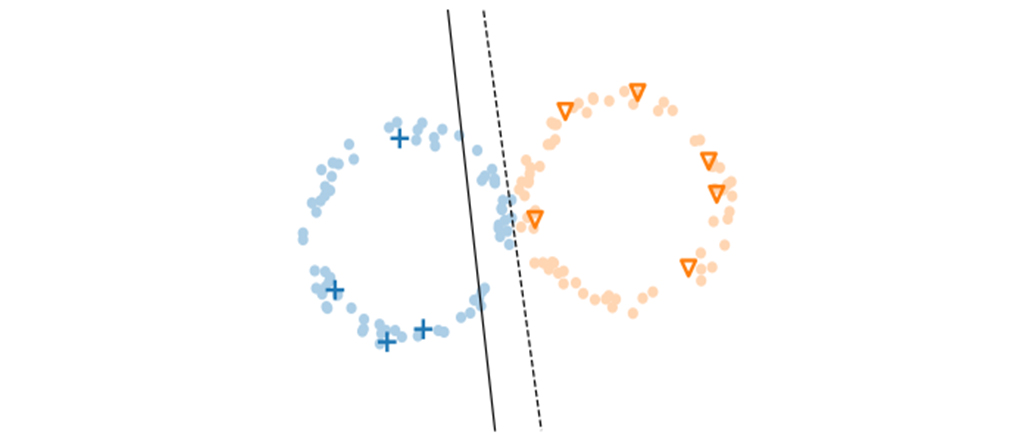

In [2]:
Image('./images/manifold-assumption.jpeg')

#### + 4. Cluster 가정 

추가적으로 언급되는 다른 가정이다. Cluster 가정은 데이터들이 같은 클러스터에 속하면 해당 데이터들은 같은 클래스에 속한다는 가정이다. 

이는 위(1~3) 가정들의 일반화로 볼 수 있는데, 이에 따르면 cluster는 다음가 같이 특정 유사도(similarity)를 기준으로 나누게 된다. 

- Smoothness 가정: 입력 공간상에서 가까운 것들을 cluster로 본다
- Low-density 가정: 확률 밀도가 높은 지역의 data point를 cluster로 본다 
- Manifold 가정: 저차원 manifold 상의 data point를 cluster로 본다.

### SSL Taxonomy

SSL은 크게 3가지 분류로 나눌 수 있다.

1. Wrapper Methods: Self-Training, Co-Training, Boosting etc

2. Consistency Regularization: Ladder Networks, Pi-model, Temporal Ensemble, Mean teachers etc

3. Hybrid/Holistic Methods: Mixmatch, Remixmatch, Fixmatch etc

해당 튜토리얼에서는 Pi-Model에서 살짝 변형된 **Temporal Ensemble** 모델을 구현한다.

Consistency Regularization 방법론의 핵심적인 motivation은 다음과 같다.

"Unlabeled 데이터에 realistic perturbation이 적용되어도 예측 결과는 크게 달라지지 않을 것!"

### Pi-Model

Pi-Model은 전형적인 consistency 방식 중 하나이다. 해당 모델의 학습 과정은 다음과 같다.

1. 동일한 입력값(x1)으로 부터 realistic perturbation (data augmentation, network dropout) 을 이용해서 두 개의 출력 값을 만든다.

2. 하나의 출력값과 실제 레이블을 이용한 loss (cross-entropy)를 계산한다 -> label 데이터만 

3. (1)에서 출력된 두 개의 값의 차이를 이용한 loss (mse)를 계산한다 -> label, unlabeled 데이터 모두

4. (2), (3)에서 계산된 loss 값을 ramp-up 방식으로 가중합(weight sum)해서 모델을 학습한다 -> 초반에는 label 데이터 비중 높게, 나중에는 줄여가면서

Pi-model의 전체적인 구조는 다음과 같다.


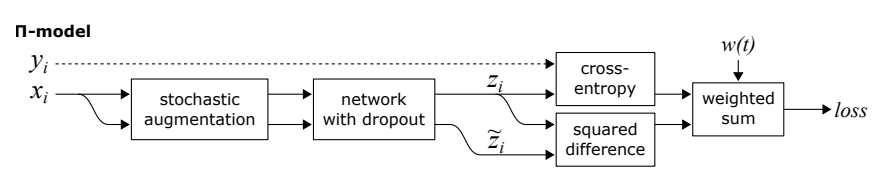

In [3]:
Image('./images/pi_model_structure.PNG')

### Temporal Ensemble Model

Temporal Ensemble Model은 Pi-model이 학습시 사용하는, training target tilda zi가 noisy 하다는 단점을 극복했다.

개별 (한 가지) 평가를 사용하는 Pi-model과는 달리 temporal ensemble 모델은 이전까지 저장된 예측 값을 사용한다.

이때 momentum parameter alpha를 이용해 이전까지의 정보를 얼마나 사용할지 정할 수 있다. 

이런 과정을 통해 Pi-model 대비 덜 noisy한 training target을 얻을 수 있고 이는 예측 성능의 향상으로 이어진다.

Temporal Ensemble 모델의 전체적인 구조는 다음과 같다.

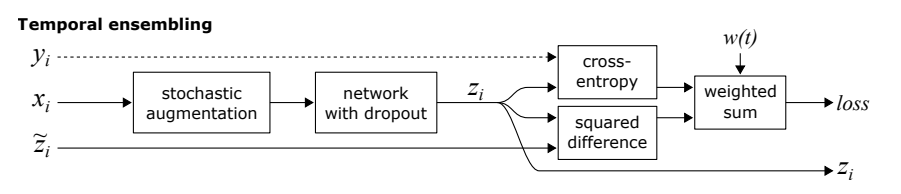

In [4]:
Image('./images/temporal_ensemble_structure.PNG')

### 1. Import Packages

In [5]:
import numpy as np
from timeit import default_timer as timer

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms

import argparse, math, time, json, os
import warnings
warnings.filterwarnings('ignore')

### 2. Load Data (해당 튜토리얼에는 CIFAR-10 데이터를 사용한다)

In [6]:
def mnist_dataset(root, transform):

    # load train data
    train_dataset = datasets.MNIST(
        root=root,
        train=True,
        transform=transform,
        download=True)

    # load test data
    test_dataset = datasets.MNIST(
        root=root,
        train=False,
        transform=transform, download=True)

    return train_dataset, test_dataset

def sample_train(train_dataset, test_dataset, batch_size, k, n_classes, seed, shuffle_train=False, return_idx=True):
    '''K: Hyperparameter로 레이블 데이터를 얼마만큼 사용할지 정함'''

    n = len(train_dataset)  # dataset size
    # print(f'Size of MNIST dataset is {n}')
    rrng = np.random.RandomState(seed) # random seed
    indices = torch.zeros(k)  # K: num of labled data ! 
    others = torch.zeros(n - k)  # indices of unlabeled data
    card = k // n_classes # 각 class에 labeled 얼마나 넣을 것인지
    cpt = 0

    for i in range(n_classes):
        class_items = (train_dataset.train_labels == i).nonzero()  # indices of samples with label i
        n_class = len(class_items)  # number of samples with label i
        # print(f'{i}번째 클래스에서 레이블이 있는 데이터의 수는{n_class}')
        rd = rrng.permutation(np.arange(n_class))  # shuffle them
        indices[i * card: (i+1) * card] = torch.squeeze(class_items[rd[:card]])
        others[cpt: cpt+n_class-card] = torch.squeeze(class_items[rd[card:]])
        cpt += (n_class-card)

    # tensor as indices must be long, byte or bool
    others = others.long()
    train_dataset.train_labels[others] = -1

    train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                               batch_size=batch_size,
                                               num_workers=2,
                                               shuffle=shuffle_train)

    test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                              batch_size=batch_size,
                                              num_workers=2,
                                              shuffle=False)

    if return_idx:
        return train_loader, test_loader, indices
    return train_loader, test_loader

### 3. Class for Realistic Perturbation (Data Augmentation and Network Dropout)
#### *Network Dropout 은 네트워크 모델 생성 파트에서 만듬

In [7]:
# Data Augmentation = Gaussian Noise

class GaussianNoise(nn.Module):
    """데이터에 Gaussican Noise 추가"""
    def __init__(self, batch_size, input_shape, std):
        super(GaussianNoise, self).__init__()
        self.shape = (batch_size, ) + input_shape
        self.std = std
        self.noise = torch.zeros(self.shape).cuda()

    def forward(self, x):
        self.noise.normal_(mean=0, std=self.std)

        return x + self.noise

### 4. Loss Function (MSE and Masked Cross Entropy)

In [8]:
# Loss 1: MSE Loss (For both of Labeled and Unlabeled Data)
# 현재의 output과 ensemble output 사이의 차이 (MSE)를 계산, unsupervised loss

def mse_loss(out1, out2):
    quad_diff = torch.sum((F.softmax(out1, dim=1) - F.softmax(out2, dim=1)) ** 2)

    return quad_diff / out1.data.nelement()

# Loss 2: Corss Entropy (For Labeled Data)
# 현재의 output과 labeled data의 output(target) 차이 (Cross Entropy)를 계산, supervised loss
def masked_crossentropy(out, labels):
    cond = (labels >= 0)
    nnz = torch.nonzero(cond)  # Supervised Data Index
    nbsup = len(nnz)  # Number of supervised samples
    
    # Batch 내부에 Labeled Sample 존재하는지 확인, 없으면 0
    if nbsup > 0:
        # select lines in out with label
        masked_outputs = torch.index_select(out, 0, nnz.view(nbsup))
        masked_labels = labels[cond]
        loss = F.cross_entropy(masked_outputs, masked_labels)
        return loss, nbsup
    
    else: loss = torch.tensor([0.], requires_grad=False).cuda()
    return loss, 0

# Final Loss (Loss 1 + Loss 2)
# Supervised + Unsupervised Loss
def temporal_losses(out1, out2, w, labels):     # w: weight for summation loss
    sup_loss, nbsup = masked_crossentropy(out1, labels)
    unsup_loss = mse_loss(out1, out2)
    total_loss = sup_loss + w * unsup_loss

    return total_loss, sup_loss, unsup_loss, nbsup

### 5. Weigth Scheduler and Ramp Up Function for Training

In [9]:
def weight_scheduler(epoch, max_epochs, max_val, mult, n_labeled, n_samples):
    "epoch이 지남에 따라 weight를 조정함"
    max_val = max_val * (float(n_labeled) / n_samples)
    return ramp_up(epoch, max_epochs, max_val, mult)

def ramp_up(epoch, max_epochs, max_val, mult):
    "weight를 조정하며 첫 epoch에는 0을 사용함"
    if epoch == 0:
        return 0.
    elif epoch >= max_epochs:
        return max_val
    return max_val * np.exp(-mult * (1. - float(epoch) / max_epochs) ** 2)

### 6. Calculatation Metric

In [10]:
# Mnist 분류 문제이기 때문에 Accuracy 사용

def calc_metrics(model, loader):
    correct = 0
    total = 0
    for i, (samples, labels) in enumerate(loader):
        samples = samples.cuda()
        labels = labels.requires_grad_(False).cuda()
        outputs = model(samples)
        _, predicted = torch.max(outputs.detach(), 1)
        total += labels.size(0)
        correct += (predicted == labels.detach().view_as(predicted)).sum()
    acc = 100 * float(correct) / total
    return acc

### 7. Base Network로 간단한 CNN 사용 (Realistic Perturbation 위해 Network Dropout = 0.5 사용)

In [11]:
class CNN(nn.Module):
    def __init__(self, batch_size, std, input_shape=(1, 28, 28), p=0.5, fm1=16, fm2=32):
        super(CNN, self).__init__()
        self.std = std
        self.p = p
        self.fm1 = fm1
        self.fm2 = fm2
        self.input_shape = input_shape
        self.conv_block1 = nn.Sequential(nn.Conv2d(1, self.fm1, 3, stride=1, padding=1),
                                        nn.BatchNorm2d(self.fm1), 
                                        nn.ReLU(),
                                        nn.MaxPool2d(3, stride=2, padding=1)
                                      )
        
        self.conv_block2 = nn.Sequential(nn.Conv2d(self.fm1, self.fm2, 3, stride=1, padding=1),
                                        nn.BatchNorm2d(self.fm2), 
                                        nn.ReLU(),
                                        nn.MaxPool2d(3, stride=2, padding=1)
                                      )
        self.drop = nn.Dropout(self.p) # Dropout for Realistic Perturbation
        self.fc = nn.Linear(self.fm2 * 7 * 7, 10)


    def forward(self, x):
        if self.training:
            b = x.size(0)
            gn = GaussianNoise(b, self.input_shape, self.std)
            x = gn(x)

        # first block
        x = self.conv_block1(x)
        
        # second block
        x = self.conv_block2(x)

        # classifier
        x = x.view(-1, self.fm2 * 7 * 7)
        x = self.fc(self.drop(x))

        return x

### 8. Train Model (Momentum Algorithm 사용해서 학습)

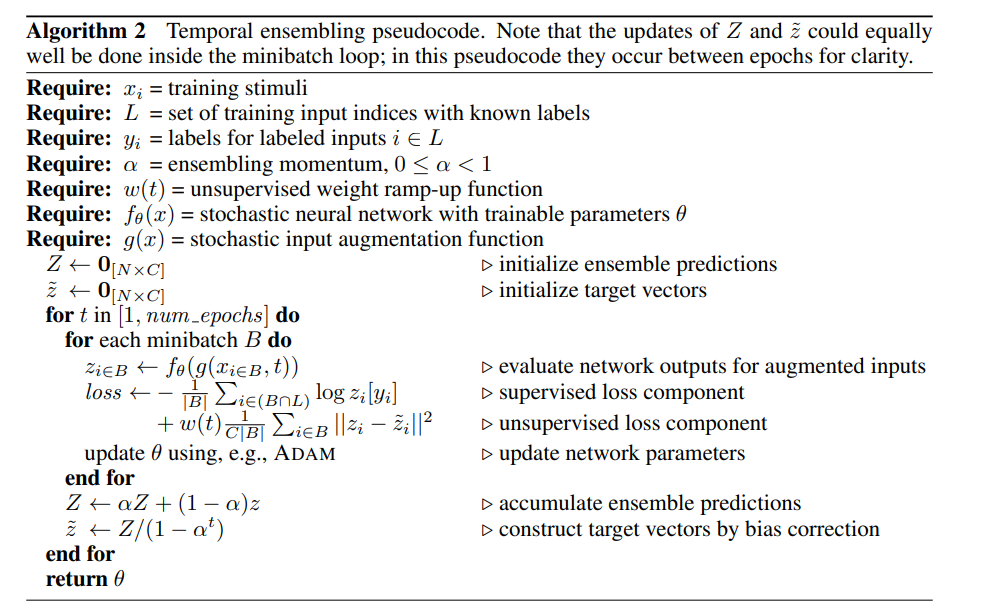

In [12]:
Image('./images/temporal_ensemble_algorithm.PNG')

In [13]:
def train(model, train_loader, val_loader ,seed, k, alpha, lr, num_epochs, batch_size, ntrain,n_classes=10, max_epochs=80, max_val=1.):

    # GPU 사용
    model.cuda()

    # Optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.99))
    
    # 첫 ensemble ouput은 모두 0
    Z = torch.zeros(ntrain, n_classes).float().cuda()  # intermediate values
    z = torch.zeros(ntrain, n_classes).float().cuda()  # temporal outputs
    outputs = torch.zeros(ntrain, n_classes).float().cuda()  # current outputs

    losses = []
    suplosses = []
    unsuplosses = []
    best_loss = 30.0
    for epoch in range(num_epochs): # 10 epoch: default
        t = timer()
        # print('\nEpoch: {}'.format(epoch+1))
        model.train()
        # evaluate unsupervised cost weight
        w = weight_scheduler(epoch, max_epochs, max_val, 5, k, 60000)

        w = torch.tensor(w, requires_grad=False).cuda()
        # print('---------------------')

        # targets change only once per epoch
        for i, (images, labels) in enumerate(train_loader):

            batch_size = images.size(0)  # retrieve batch size again cause drop last is false
            images = images.cuda()
            labels = labels.requires_grad_(False).cuda()

            optimizer.zero_grad()
            out = model(images)
            # 현재 batch에 맞는 ensemble 결과들을 가져옴
            # z and zcomp for temporal lossed
            zcomp = z[i * batch_size: (i+1) * batch_size]
            zcomp.requires_grad_(False)
            loss, suploss, unsuploss, nbsup = temporal_losses(out, zcomp, w, labels)

            # save outputs
            outputs[i * batch_size: (i+1) * batch_size] = out.clone().detach()
            losses.append(loss.item())
            suplosses.append(nbsup * suploss.item())
            unsuplosses.append(unsuploss.item())

            # backprop
            loss.backward()
            optimizer.step()

        loss_mean = np.mean(losses)
        supl_mean = np.mean(suplosses)
        unsupl_mean = np.mean(unsuplosses)
        
        # model의 outputs을 가중평균을 이용해 ensemble outputs으로 update 함
        # 여기가 alpha 값 업데이트 하는 부분
        Z = alpha * Z + (1. - alpha) * outputs
        z = Z * (1. / (1. - alpha ** (epoch + 1)))

        if loss_mean < best_loss:
            best_loss = loss_mean
            torch.save({'state_dict': model.state_dict()}, 'model_best.pth')

        model.eval()
        acc = calc_metrics(model, val_loader)
        # print('Acc : %.2f' % acc)

def evaluation(model, loader):

    # test best model
    checkpoint = torch.load('model_best.pth')
    model.load_state_dict(checkpoint['state_dict'])
    model.eval()
    correct = 0
    total = 0
    for i, (samples, labels) in enumerate(loader):
        samples = samples.cuda()
        labels = labels.requires_grad_(False).cuda()
        outputs = model(samples)
        _, predicted = torch.max(outputs.detach(), 1)
        total += labels.size(0)
        correct += (predicted == labels.detach().view_as(predicted)).sum()
    acc = 100 * float(correct) / total
    print('Acc (best model): %.2f' % acc)
    print('---------------------')

### 9. Pi-Model Experiment

In [14]:
# prepare data

for k in [100, 1000, 5000, 10000]:
      print(f'Labeled Data의 수가 {k}일때 실험을 시작합니다.')
      transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(0.1307, 0.3081)]) # Data Normalize
      train_dataset, val_dataset = mnist_dataset(root='~/datasets/MNIST', transform=transform) # 
      ntrain = len(train_dataset)

      model = CNN(batch_size=64, # batch size
                  std = 0.15, # std of gaussian noise,
                  fm1 = 32, # channels of the first con
                  fm2 = 64 # channels of the second conv
                  ).cuda()
                  
      seed = 951117
      train_loader, val_loader, indices = sample_train(train_dataset, val_dataset, 
                                                      batch_size=64,
                                                      k=k, # Labeled 데이터 개수!
                                                      n_classes=10, # MNIST Class 개수
                                                      seed=seed, 
                                                      shuffle_train=False)
            
      train(model, train_loader, val_loader, seed, 
            k=k, # Labeled 데이터 개수! (10의 배수로 넣어야됨)
            alpha = 0.6, # Temporal Ensembling momentum
            lr = 0.002,
            num_epochs=10,
            batch_size=64,
            ntrain= ntrain)
      # print(f'Labeled Data 수가 {k} 개일 때')
      evaluation(model, val_loader)

Labeled Data의 수가 100일때 실험을 시작합니다.
Acc (best model): 84.97
---------------------
Labeled Data의 수가 1000일때 실험을 시작합니다.
Acc (best model): 96.39
---------------------
Labeled Data의 수가 5000일때 실험을 시작합니다.
Acc (best model): 98.16
---------------------
Labeled Data의 수가 10000일때 실험을 시작합니다.
Acc (best model): 98.60
---------------------


### 10. Conclusion

1. MNIST 데이터는 총 60000개의 학습 데이터와 10000개의 실험 데이터로 이루어져 있다.

2. SSL(Semi-Supervised Learning)은 Labeled Data와 Unlabeled 데이터를 모두 사용하는 학습 방법이다.

3. Labeled 데이터의 수를 100, 1000, 5000, 10000으로 바꿔가며 실험한 결과 Labeled 데이터의 수가 증가할 수록 성능이 올라갔다.

4. 이는 (상식적으로 생각해도) Labeled 데이터를 통한 학습이 Unlabeled 데이터보다 쉽기 때문에 Labeled 데이터의 비중이 높을수록 성능이 올라가기 때문이다.

5. 다만 Labeled 데이터의 수가 100처럼 작은 경우에도 나쁘지 않은 성능을 보여주었다.